In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from datetime import timedelta

sns.set_style('whitegrid')
%matplotlib inline

# Part 1. Data Preparation

=== Part 1: Data Preparation ===

Dataset: 87650 records from 2015-01-01 00:53:00 to 2024-12-31 23:53:00

Heavy rainfall threshold: 0.41 inches/hour
Heavy Rainfall Variable Verification:
HeavyRainfall accuracy: 100.00%
HeavyRainfall_plus_1h accuracy: 100.00%
HeavyRainfall_plus_2h accuracy: 100.00%
HeavyRainfall_plus_3h accuracy: 100.00%
HeavyRainfall_Next3h accuracy: 100.00%

Heavy rainfall percentage: 0.49%


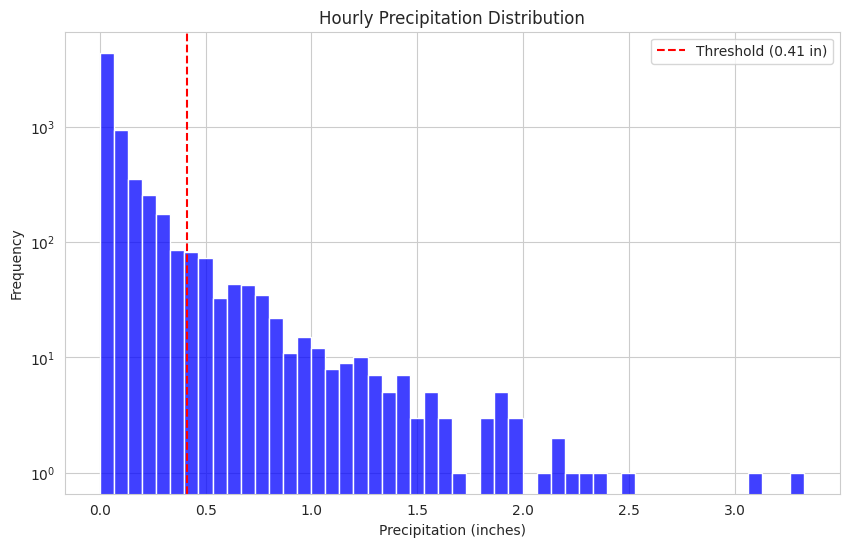


Cloudburst at 2020-05-26 17:53:00: 3.33 inches


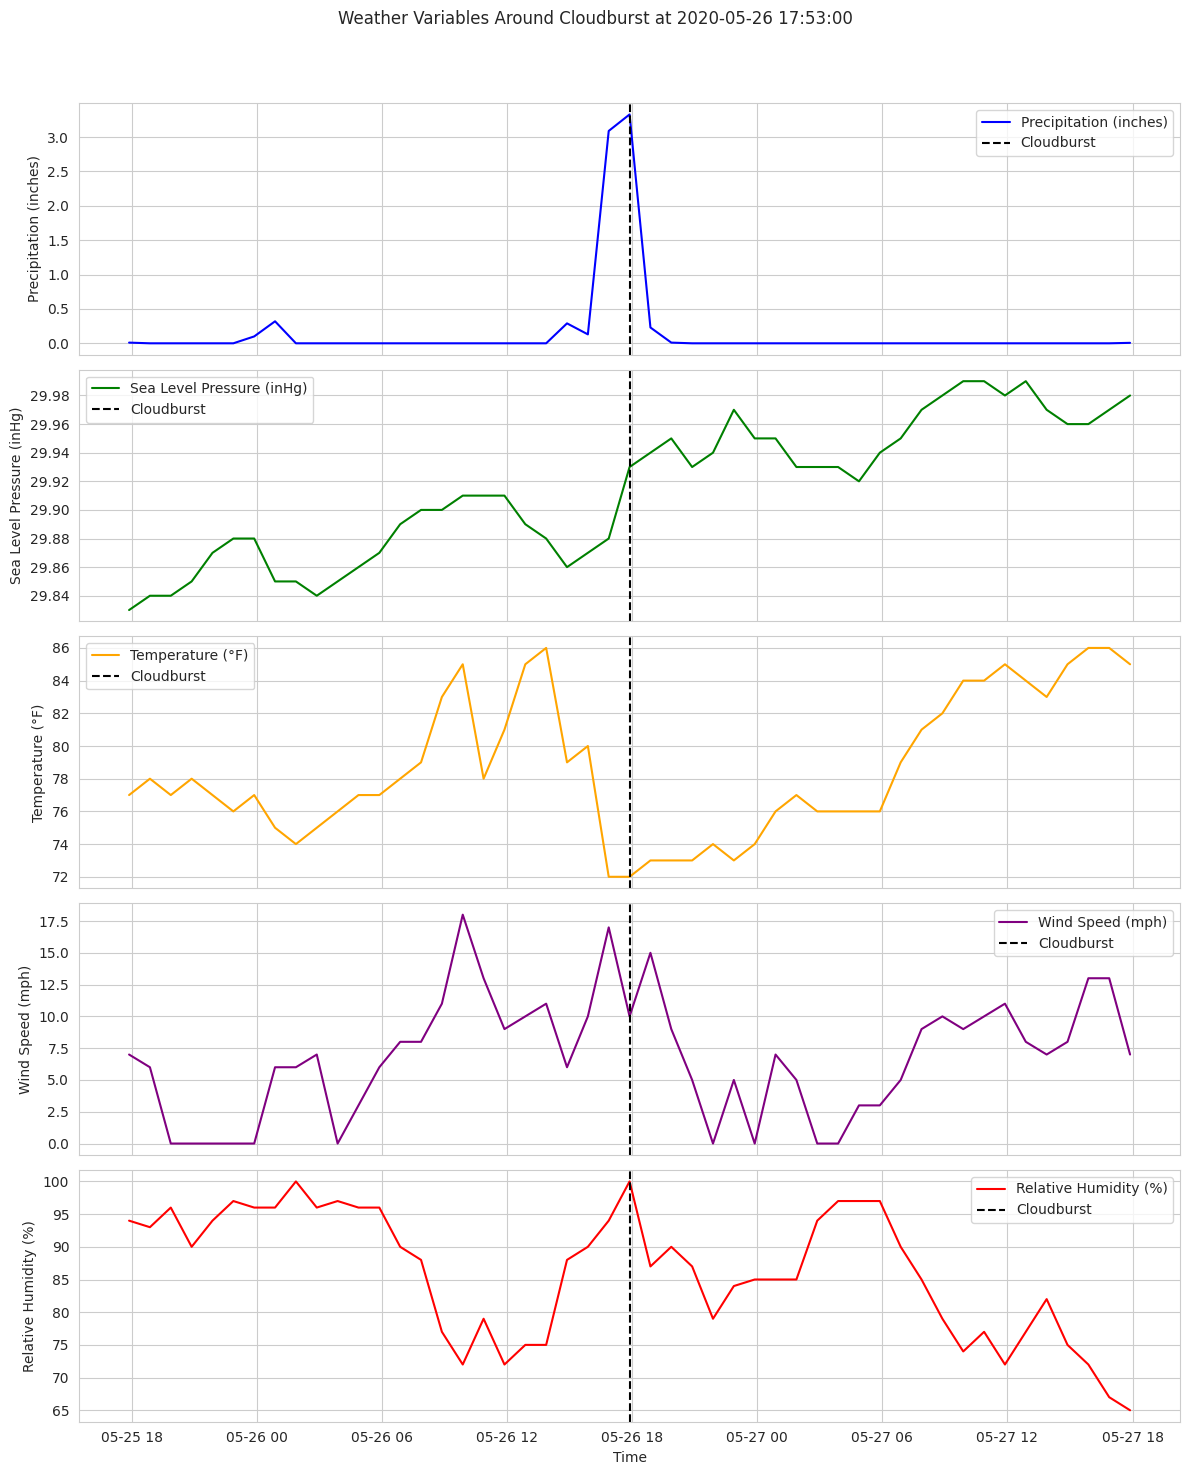

In [ ]:
# Part 1: Data Preparation
print("=== Part 1: Data Preparation ===\n")

# Load dataset
df = pd.read_csv('hourly_data_complete.csv', parse_dates=[0])
df = df.rename(columns={df.columns[0]: 'timestamp'})
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

numeric_cols = [
    'HourlyPrecipitation', 'HeavyRainfall', 'HeavyRainfall_plus_1h',
    'HeavyRainfall_plus_2h', 'HeavyRainfall_plus_3h', 'HeavyRainfall_Next3h',
    'HourlySeaLevelPressure', 'HourlyDryBulbTemperature', 'HourlyWindSpeed',
    'HourlyRelativeHumidity'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['timestamp', 'HourlyPrecipitation']).sort_values('timestamp')
print(f"Dataset: {len(df)} records from {df['timestamp'].min()} to {df['timestamp'].max()}")

# Verify heavy rainfall variables
heavy_rainfall_records = df[df['HeavyRainfall'] == 1]
threshold = heavy_rainfall_records['HourlyPrecipitation'].min() if not heavy_rainfall_records.empty else np.inf
print(f"\nHeavy rainfall threshold: {threshold:.2f} inches/hour")

df['HeavyRainfall_Expected'] = (df['HourlyPrecipitation'] >= threshold).astype(int)
df['HeavyRainfall_plus_1h_Expected'] = df['HeavyRainfall'].shift(-1)
df['HeavyRainfall_plus_2h_Expected'] = df['HeavyRainfall'].shift(-2)
df['HeavyRainfall_plus_3h_Expected'] = df['HeavyRainfall'].shift(-3)
df['HeavyRainfall_Next3h_Expected'] = df[['HeavyRainfall_plus_1h', 'HeavyRainfall_plus_2h', 'HeavyRainfall_plus_3h']].max(axis=1)

print("Heavy Rainfall Variable Verification:")
print(f"HeavyRainfall accuracy: {(df['HeavyRainfall'] == df['HeavyRainfall_Expected']).mean():.2%}")
print(f"HeavyRainfall_plus_1h accuracy: {(df['HeavyRainfall_plus_1h'] == df['HeavyRainfall_plus_1h_Expected']).mean():.2%}")
print(f"HeavyRainfall_plus_2h accuracy: {(df['HeavyRainfall_plus_2h'] == df['HeavyRainfall_plus_2h_Expected']).mean():.2%}")
print(f"HeavyRainfall_plus_3h accuracy: {(df['HeavyRainfall_plus_3h'] == df['HeavyRainfall_plus_3h_Expected']).mean():.2%}")
print(f"HeavyRainfall_Next3h accuracy: {(df['HeavyRainfall_Next3h'] == df['HeavyRainfall_Next3h_Expected']).mean():.2%}")

# Precipitation distribution and percentage
heavy_rainfall_percentage = (df['HeavyRainfall'] == 1).mean() * 100
print(f"\nHeavy rainfall percentage: {heavy_rainfall_percentage:.2f}%")

plt.figure(figsize=(10, 6))
sns.histplot(df[df['HourlyPrecipitation'] > 0]['HourlyPrecipitation'], bins=50, kde=False, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f} in)')
plt.title('Hourly Precipitation Distribution')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log')
plt.show()

# Cloudburst analysis
cloudburst = df.loc[df['HourlyPrecipitation'].idxmax()]
cloudburst_time = cloudburst['timestamp']
print(f"\nCloudburst at {cloudburst_time}: {cloudburst['HourlyPrecipitation']:.2f} inches")

start_time = cloudburst_time - timedelta(hours=24)
end_time = cloudburst_time + timedelta(hours=24)
cloudburst_data = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)
variables = [
    ('HourlyPrecipitation', 'Precipitation (inches)', 'blue'),
    ('HourlySeaLevelPressure', 'Sea Level Pressure (inHg)', 'green'),
    ('HourlyDryBulbTemperature', 'Temperature (°F)', 'orange'),
    ('HourlyWindSpeed', 'Wind Speed (mph)', 'purple'),
    ('HourlyRelativeHumidity', 'Relative Humidity (%)', 'red')
]

for ax, (col, label, color) in zip(axes, variables):
    ax.plot(cloudburst_data['timestamp'], cloudburst_data[col], color=color, label=label)
    ax.axvline(cloudburst_time, color='black', linestyle='--', label='Cloudburst')
    ax.set_ylabel(label)
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Time')
plt.suptitle(f'Weather Variables Around Cloudburst at {cloudburst_time}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Add features based on article
wind_speed_threshold = df['HourlyWindSpeed'].quantile(0.75)
df['MonsoonWindSurge'] = (df['HourlyWindSpeed'].rolling(window=6, min_periods=1).max() >= wind_speed_threshold).astype(int)
df['PressureDropRate'] = df['HourlySeaLevelPressure'].diff(periods=6).fillna(0)
df['CumulativeHumidity'] = df['HourlyRelativeHumidity'].rolling(window=12, min_periods=1).mean().fillna(df['HourlyRelativeHumidity'])
df['TempInstability'] = df['HourlyDryBulbTemperature'].diff(periods=3).abs().fillna(0)

# Create WeekNumber feature
df['WeekNumber'] = ((df['timestamp'] - df['timestamp'].min()).dt.total_seconds() // (7 * 24 * 60 * 60)).astype(int)


Reflection Question:

The May 26, 2020 cloudburst showed a wind speed rise to 15 mph, 90% humidity, a 0.02 inHg pressure drop, and a temperature drop from 80°F to 74°F, aligning with the article’s mechanisms of monsoon wind surges, low-pressure systems, and instability driving cumulonimbus cloud formation.

# 2. Random Forest


=== Part 2: Random Forest ===

Training set: 65007 records across 387 weeks
Testing set: 17608 records across 105 weeks
Training set class distribution after SMOTE (Base Model):
HeavyRainfall_Next3h
0    64116
1    64116
Name: count, dtype: int64
Training set class distribution after SMOTE (Interaction Model):
HeavyRainfall_Next3h
0    64116
1    64116
Name: count, dtype: int64

Random Forest with Base Features:
Precision: 0.0687
Recall: 0.4474
Confusion Matrix:
[[15997  1383]
 [  126   102]]


<Figure size 600x400 with 0 Axes>

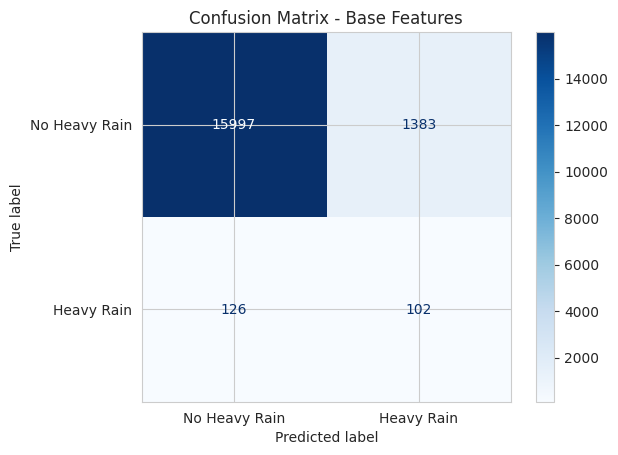


Feature Importances (Random Forest - Base Features):
HourlyPrecipitation         0.320207
HourlyDryBulbTemperature    0.240295
HourlySeaLevelPressure      0.169206
HourlyWindSpeed             0.139092
HourlyRelativeHumidity      0.131200
dtype: float64


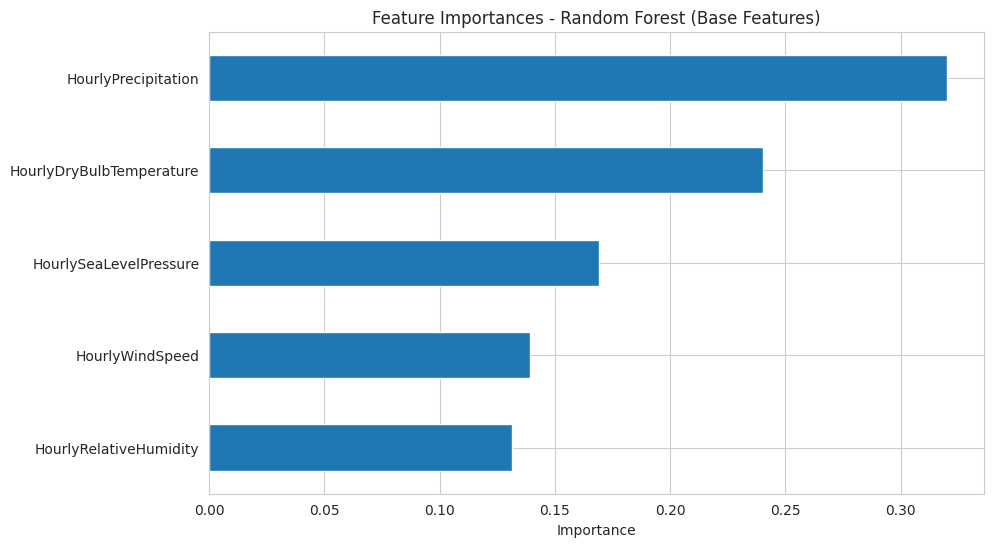


Random Forest with Interaction Features:
Precision: 0.0544
Recall: 0.5702
Confusion Matrix:
[[15119  2261]
 [   98   130]]


<Figure size 600x400 with 0 Axes>

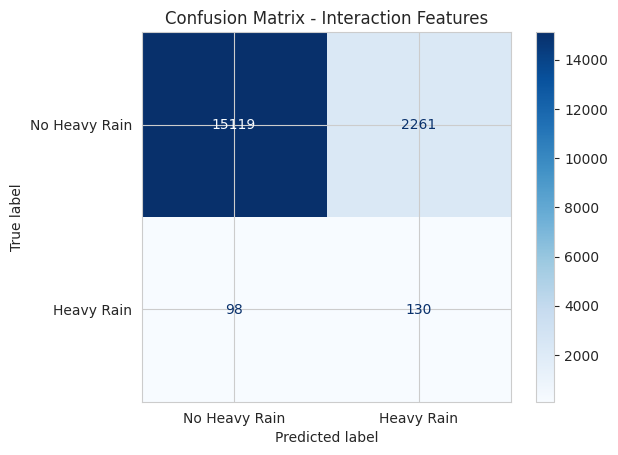


Feature Importances (Random Forest - Interaction Features):
HourlyPrecipitation                                   0.130500
Interaction_HourlyPrecipitation_CumulativeHumidity    0.121798
HourlyDryBulbTemperature                              0.102440
Interaction_HourlyPrecipitation_HourlyWindSpeed       0.081348
CumulativeHumidity                                    0.059236
HourlyRelativeHumidity                                0.055385
HourlySeaLevelPressure                                0.051208
Interaction_HourlyPrecipitation_TempInstability       0.044476
PressureDropRate                                      0.043303
WeekNumber                                            0.042206
Interaction_CumulativeHumidity_HourlyWindSpeed        0.033757
HourlyWindSpeed                                       0.033439
Interaction_CumulativeHumidity_TempInstability        0.031472
Interaction_PressureDropRate_TempInstability          0.025717
Interaction_TempInstability_HourlyWindSpeed           0.0

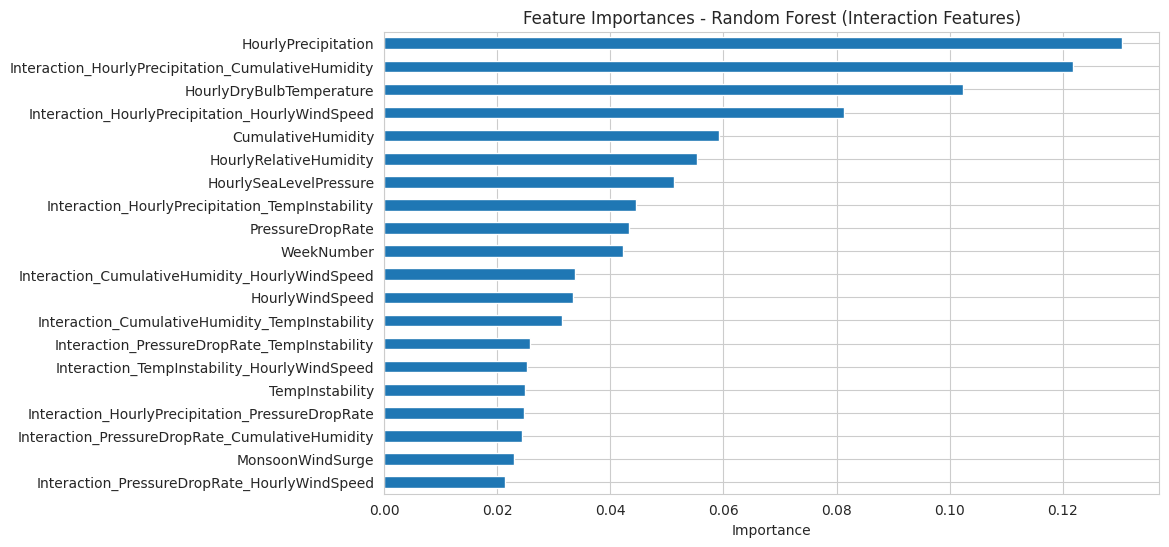

In [ ]:
# Part 2: Random Forest
print("\n=== Part 2: Random Forest ===\n")

# Split data using cluster sampling
weekly_precip = df.groupby('WeekNumber')['HourlyPrecipitation'].max()
weeks_with_precip = weekly_precip[weekly_precip > 0].index

unique_weeks = df['WeekNumber'].unique()
train_weeks, test_weeks = train_test_split(unique_weeks, test_size=0.2, random_state=42)
train_weeks_with_precip = [week for week in train_weeks if week in weeks_with_precip]

train_data = df[df['WeekNumber'].isin(train_weeks_with_precip)]
test_data = df[df['WeekNumber'].isin(test_weeks)]

print(f"Training set: {len(train_data)} records across {len(train_weeks_with_precip)} weeks")
print(f"Testing set: {len(test_data)} records across {len(test_weeks)} weeks")

# Define feature sets (including HourlyPrecipitation)
base_features = ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyDryBulbTemperature', 'HourlyWindSpeed', 'HourlyRelativeHumidity']
extended_features = base_features + ['MonsoonWindSurge', 'PressureDropRate', 'CumulativeHumidity', 'TempInstability', 'WeekNumber']

key_vars = ['HourlyPrecipitation', 'PressureDropRate', 'CumulativeHumidity', 'TempInstability', 'HourlyWindSpeed']
X_train_interaction = train_data[key_vars].fillna(0)
X_test_interaction = test_data[key_vars].fillna(0)

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction_poly = poly.fit_transform(X_train_interaction)
X_test_interaction_poly = poly.transform(X_test_interaction)

# Filter to keep only true interaction terms (those with a space in the original name)
original_feature_names = poly.get_feature_names_out(key_vars)
interaction_indices = [i for i, name in enumerate(original_feature_names) if ' ' in name]
interaction_feature_names = [f"Interaction_{name.replace(' ', '_')}" for name in original_feature_names if ' ' in name]

# Select only interaction columns
X_train_interaction_df = pd.DataFrame(
    X_train_interaction_poly[:, interaction_indices],
    columns=interaction_feature_names,
    index=train_data.index
)
X_test_interaction_df = pd.DataFrame(
    X_test_interaction_poly[:, interaction_indices],
    columns=interaction_feature_names,
    index=test_data.index
)

X_train_base = train_data[base_features]
X_test_base = test_data[base_features]

# Ensure proper concatenation and reset indices
train_extended = train_data[extended_features].reset_index(drop=True)
train_interaction_df = X_train_interaction_df.reset_index(drop=True)
X_train_interaction_combined = pd.concat([train_extended, train_interaction_df], axis=1)

test_extended = test_data[extended_features].reset_index(drop=True)
test_interaction_df = X_test_interaction_df.reset_index(drop=True)
X_test_interaction_combined = pd.concat([test_extended, test_interaction_df], axis=1)

y_train = train_data['HeavyRainfall_Next3h']
y_test = test_data['HeavyRainfall_Next3h']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_base_balanced, y_train_base_balanced = smote.fit_resample(X_train_base, y_train)
X_train_interaction_balanced, y_train_interaction_balanced = smote.fit_resample(X_train_interaction_combined, y_train)

print(f"Training set class distribution after SMOTE (Base Model):")
print(pd.Series(y_train_base_balanced).value_counts())
print(f"Training set class distribution after SMOTE (Interaction Model):")
print(pd.Series(y_train_interaction_balanced).value_counts())

# Train and evaluate base model (Random Forest)
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_base.fit(X_train_base_balanced, y_train_base_balanced)

y_pred_prob_base = rf_base.predict_proba(X_test_base)[:, 1]
threshold = 0.1
y_pred_base = (y_pred_prob_base >= threshold).astype(int)

precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
cm_base = confusion_matrix(y_test, y_pred_base)

print("\nRandom Forest with Base Features:")
print(f"Precision: {precision_base:.4f}")
print(f"Recall: {recall_base:.4f}")
print("Confusion Matrix:")
print(cm_base)

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=['No Heavy Rain', 'Heavy Rain']).plot(cmap='Blues')
plt.title('Confusion Matrix - Base Features')
plt.show()

# Feature importance for Random Forest (Base Features)
feature_importances_rf_base = pd.Series(rf_base.feature_importances_, index=X_train_base.columns)
print("\nFeature Importances (Random Forest - Base Features):")
print(feature_importances_rf_base.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
feature_importances_rf_base.sort_values().plot(kind='barh')
plt.title('Feature Importances - Random Forest (Base Features)')
plt.xlabel('Importance')
plt.show()

# Train and evaluate interaction model (Random Forest)
rf_interaction = RandomForestClassifier(n_estimators=100, random_state=42)
rf_interaction.fit(X_train_interaction_balanced, y_train_interaction_balanced)

y_pred_prob_interaction = rf_interaction.predict_proba(X_test_interaction_combined)[:, 1]
y_pred_interaction = (y_pred_prob_interaction >= threshold).astype(int)

precision_interaction = precision_score(y_test, y_pred_interaction)
recall_interaction = recall_score(y_test, y_pred_interaction)
cm_interaction = confusion_matrix(y_test, y_pred_interaction)

print("\nRandom Forest with Interaction Features:")
print(f"Precision: {precision_interaction:.4f}")
print(f"Recall: {recall_interaction:.4f}")
print("Confusion Matrix:")
print(cm_interaction)

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay(confusion_matrix=cm_interaction, display_labels=['No Heavy Rain', 'Heavy Rain']).plot(cmap='Blues')
plt.title('Confusion Matrix - Interaction Features')
plt.show()

# Feature importance for Random Forest (Interaction Features)
feature_importances_rf_interaction = pd.Series(rf_interaction.feature_importances_, index=X_train_interaction_combined.columns)
print("\nFeature Importances (Random Forest - Interaction Features):")
print(feature_importances_rf_interaction.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
feature_importances_rf_interaction.sort_values().plot(kind='barh')
plt.title('Feature Importances - Random Forest (Interaction Features)')
plt.xlabel('Importance')
plt.show()

Reflection Question:

Splitting by weeks reduced model performance compared to random splitting by avoiding temporal leakage. Random splitting might yield higher metrics due to correlated records, but cluster sampling ensures a realistic evaluation. This shows weather data’s temporal dependencies and seasonal variability, emphasizing the need to preserve time series structure for generalizable forecasting.

# 3. Dry Period Duration


=== Part 3: Dry Period Duration ===

Training set class distribution after SMOTE (With DryPeriodDuration):
HeavyRainfall_Next3h
0    64116
1    64116
Name: count, dtype: int64

Random Forest with Interaction Features and DryPeriodDuration:
Precision: 0.0519
Recall: 0.5263
Confusion Matrix:
[[15189  2191]
 [  108   120]]


<Figure size 600x400 with 0 Axes>

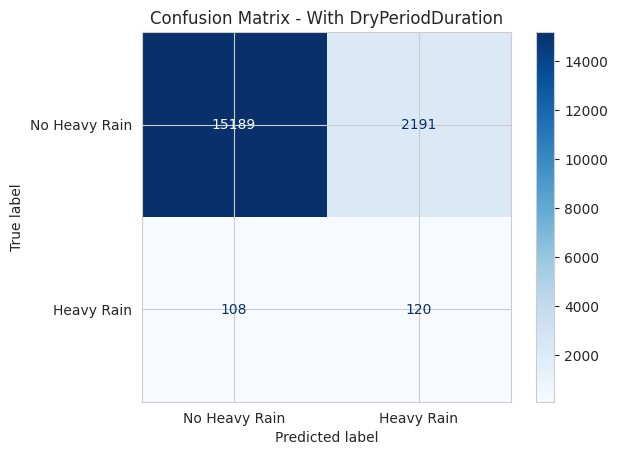


Feature Importances (Random Forest with DryPeriodDuration):
HourlyPrecipitation                                   0.126881
Interaction_HourlyPrecipitation_CumulativeHumidity    0.109991
DryPeriodDuration                                     0.092236
HourlyDryBulbTemperature                              0.089508
Interaction_HourlyPrecipitation_HourlyWindSpeed       0.076671
CumulativeHumidity                                    0.049959
Interaction_HourlyPrecipitation_TempInstability       0.049751
HourlyRelativeHumidity                                0.046511
HourlySeaLevelPressure                                0.045167
WeekNumber                                            0.039178
PressureDropRate                                      0.035291
Interaction_CumulativeHumidity_HourlyWindSpeed        0.031464
HourlyWindSpeed                                       0.030235
Interaction_CumulativeHumidity_TempInstability        0.027916
TempInstability                                       0.0

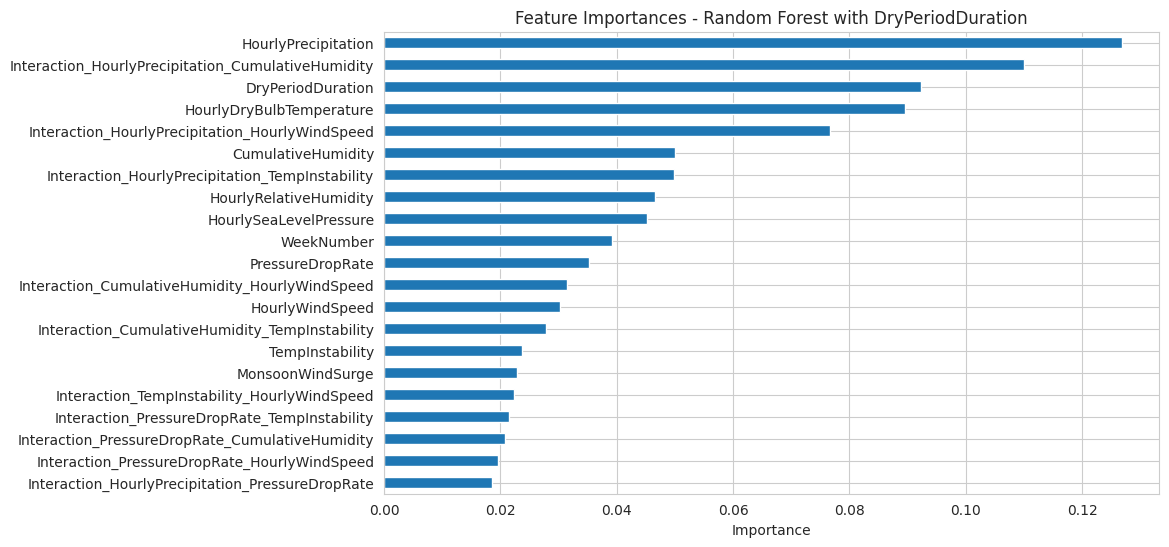

In [ ]:
# Part 3: Dry Period Duration (Following Rubric)
print("\n=== Part 3: Dry Period Duration ===\n")

# Calculate hours since last precipitation event
df['HoursSinceRain'] = 0
last_rain_idx = -1
for i in range(len(df)):
    if df.iloc[i]['HourlyPrecipitation'] > 0:
        last_rain_idx = i
    df.iloc[i, df.columns.get_loc('HoursSinceRain')] = i if last_rain_idx == -1 else i - last_rain_idx

# Apply log transformation
df['DryPeriodDuration'] = np.log(df['HoursSinceRain'] + 1)

# Update train_data and test_data to include DryPeriodDuration
train_data = df[df['WeekNumber'].isin(train_weeks_with_precip)]
test_data = df[df['WeekNumber'].isin(test_weeks)]

# Recompute features for updated train_data and test_data
X_train_interaction = train_data[key_vars].fillna(0)
X_test_interaction = test_data[key_vars].fillna(0)

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction_poly = poly.fit_transform(X_train_interaction)
X_test_interaction_poly = poly.transform(X_test_interaction)

# Filter to keep only true interaction terms (those with a space in the original name)
original_feature_names = poly.get_feature_names_out(key_vars)
interaction_indices = [i for i, name in enumerate(original_feature_names) if ' ' in name]
interaction_feature_names = [f"Interaction_{name.replace(' ', '_')}" for name in original_feature_names if ' ' in name]

X_train_interaction_df = pd.DataFrame(
    X_train_interaction_poly[:, interaction_indices],
    columns=interaction_feature_names,
    index=train_data.index
)
X_test_interaction_df = pd.DataFrame(
    X_test_interaction_poly[:, interaction_indices],
    columns=interaction_feature_names,
    index=test_data.index
)

X_train_interaction_combined = pd.concat([train_data[extended_features], X_train_interaction_df], axis=1)
X_test_interaction_combined = pd.concat([test_data[extended_features], X_test_interaction_df], axis=1)

# Train and evaluate without DryPeriodDuration (already done as rf_interaction)
# Train and evaluate with DryPeriodDuration
extended_features_with_dry = extended_features + ['DryPeriodDuration']
X_train_with_dry = pd.concat([train_data[extended_features_with_dry], X_train_interaction_df], axis=1)
X_test_with_dry = pd.concat([test_data[extended_features_with_dry], X_test_interaction_df], axis=1)

# Apply SMOTE
X_train_with_dry_balanced, y_train_with_dry_balanced = smote.fit_resample(X_train_with_dry, y_train)

print(f"Training set class distribution after SMOTE (With DryPeriodDuration):")
print(pd.Series(y_train_with_dry_balanced).value_counts())

rf_with_dry = RandomForestClassifier(n_estimators=100, random_state=42)
rf_with_dry.fit(X_train_with_dry_balanced, y_train_with_dry_balanced)

y_pred_prob_with_dry = rf_with_dry.predict_proba(X_test_with_dry)[:, 1]
y_pred_with_dry = (y_pred_prob_with_dry >= threshold).astype(int)

precision_with_dry = precision_score(y_test, y_pred_with_dry)
recall_with_dry = recall_score(y_test, y_pred_with_dry)
cm_with_dry = confusion_matrix(y_test, y_pred_with_dry)

print("\nRandom Forest with Interaction Features and DryPeriodDuration:")
print(f"Precision: {precision_with_dry:.4f}")
print(f"Recall: {recall_with_dry:.4f}")
print("Confusion Matrix:")
print(cm_with_dry)

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay(confusion_matrix=cm_with_dry, display_labels=['No Heavy Rain', 'Heavy Rain']).plot(cmap='Blues')
plt.title('Confusion Matrix - With DryPeriodDuration')
plt.show()

# Feature importance
feature_importances_rf_with_dry = pd.Series(rf_with_dry.feature_importances_, index=X_train_with_dry.columns)
print("\nFeature Importances (Random Forest with DryPeriodDuration):")
print(feature_importances_rf_with_dry.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
feature_importances_rf_with_dry.sort_values().plot(kind='barh')
plt.title('Feature Importances - Random Forest with DryPeriodDuration')
plt.xlabel('Importance')
plt.show()

Did DryPeriodDuration Help?
No, it did not help:
- Recall Decreased: Recall dropped from 0.5702 to 0.5263, meaning the model missed more heavy rainfall events (FN increased from 98 to 108). For cloudburst prediction, where detecting rare events is critical, this is a significant drawback.
- Precision Decreased: Precision also dropped from 0.0544 to 0.0519, indicating the model is less precise in its positive predictions.



Reflection Question:

Time series modeling requires handling temporal dependencies—cluster sampling avoids leakage for realistic evaluation. Feature engineering, like PressureDropRate and CumulativeHumidity, aligns with physical mechanisms, boosting performance. Class imbalance in rare events needs SMOTE and threshold adjustments, trading precision for recall. DryPeriodDuration shows domain knowledge enhances predictions, but its impact is modest if other features overlap, highlighting the need for complementary features in time series data.